In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

comp_dir = Path('/Users/rishav/Documents/Sem_4/Machine_learning and Pattern_recognition/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)


/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_78941/263069810.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(
/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_78941/263069810.py:24: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


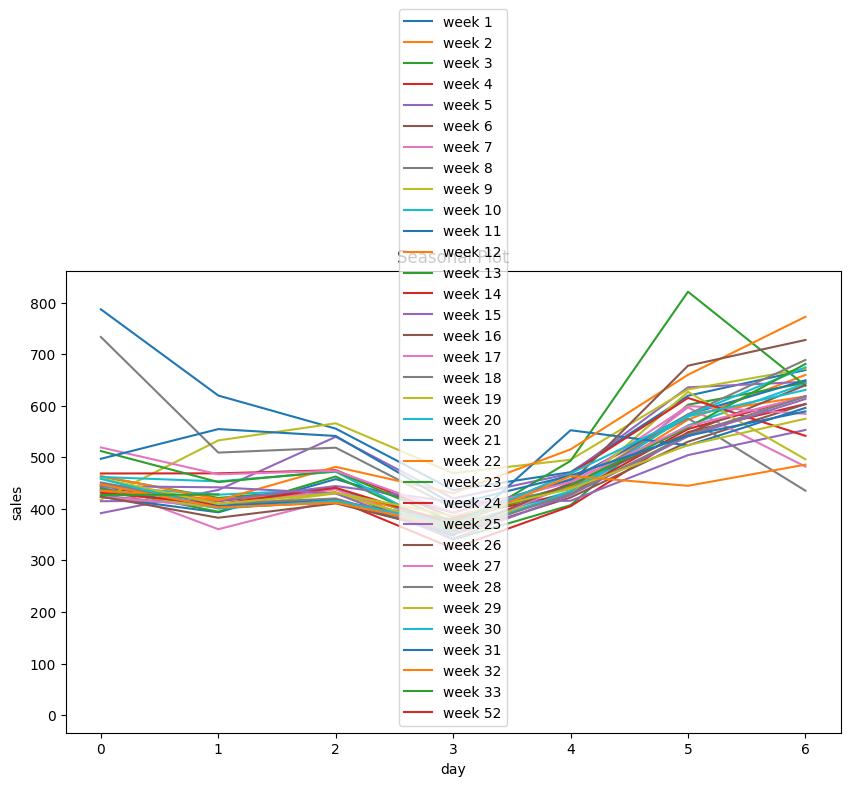

In [151]:
import matplotlib.pyplot as plt

def seasonal_plot(data, y, period, freq):
    periods = sorted(data[period].unique())
    fig, ax = plt.subplots(figsize=(10, 6))
    for p in periods:
        subset = data[data[period] == p]
        subset.plot(x=freq, y=y, ax=ax, label=f'{period} {p}')
    ax.set_ylabel(y)
    ax.set_title('Seasonal Plot')
    plt.legend()
    plt.show()

X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek


seasonal_plot(X, y='sales', period='week', freq='day')


In [152]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

/Users/rishav/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


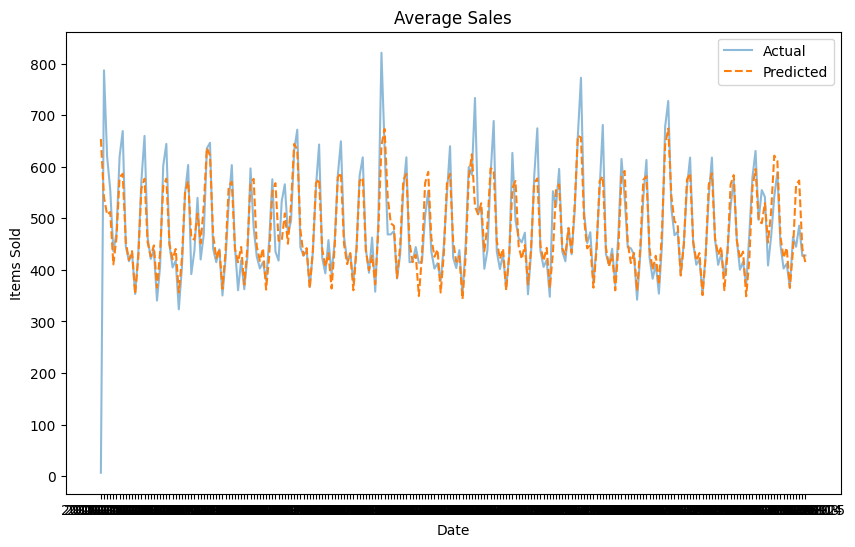

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y.index = y.index.astype(str)
y_pred.index = y_pred.index.astype(str)

plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', alpha=0.5, linestyle='-')
plt.plot(y_pred.index, y_pred, label='Predicted', linestyle='--')
plt.title("Average Sales")
plt.xlabel("Date")
plt.ylabel("Items Sold")
plt.legend()
plt.show()


In [154]:
y_deseason = y - y_pred

In [155]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


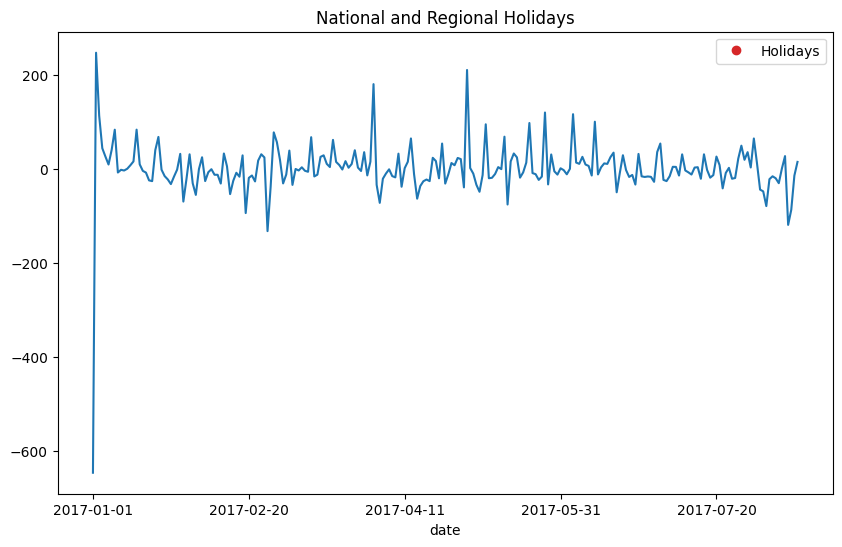

In [156]:
import matplotlib.pyplot as plt


holidays_dates = holidays.index.to_timestamp()


y_deseason_aligned = y_deseason.reindex(holidays_dates)

plot_params = {
    'figsize': (10, 6),
    'title': 'National and Regional Holidays'
}

ax = y_deseason.plot(**plot_params)
plt.plot(holidays_dates, y_deseason_aligned, color='C3', marker='o', linestyle='None', label='Holidays')
ax.set_title(plot_params['title'])
plt.legend()
plt.show()


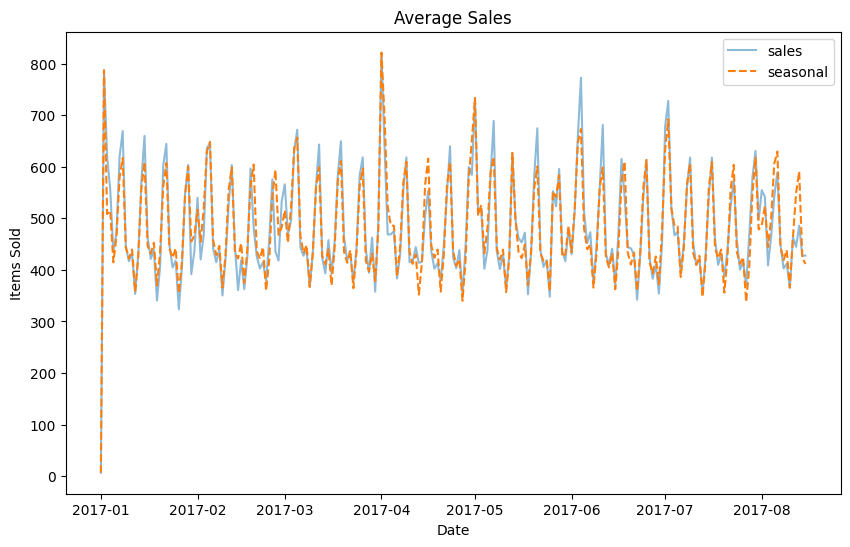

In [157]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(model.predict(X2), index=X2.index)

y.index = pd.to_datetime(y.index)


plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='sales', alpha=0.5, linestyle='-')
plt.plot(y_pred.index, y_pred, label='seasonal', linestyle='--')
plt.title("Average Sales")
plt.xlabel("Date")
plt.ylabel("Items Sold")
plt.legend()

plt.show()



In [158]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]



fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

/Users/rishav/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


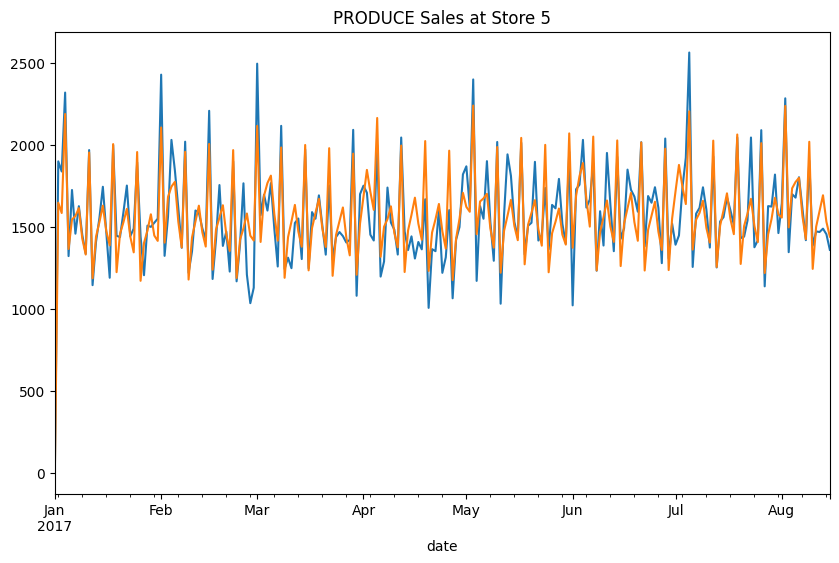

In [159]:
STORE_NBR = '5' 
FAMILY = 'PRODUCE'


ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [161]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()


X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
print(y_submit)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('/Users/rishav/Downloads/submission.csv', index=False)


                sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-16   4.274030       0.0  3.495530  2414.541711  0.438314   396.437179   
2017-08-17   4.231962       0.0  2.925768  2095.099655  0.085646   349.410230   
2017-08-18   5.353637       0.0  2.553360  2337.938007  0.046427   361.688345   
2017-08-19   4.456659       0.0  3.372807  2523.180534 -0.224578   389.076928   
2017-08-20   1.819737       0.0  1.519799  1108.174532 -0.241726   143.517880   
2017-08-21   4.101538       0.0  3.425988  2301.744283 -0.207492   360.077059   
2017-08-22   4.518885       0.0  3.980471  2362.414521  0.176839   339.221133   
2017-08-23   5.422242       0.0  4.210974  2499.280285  0.331299   402.658530   
2017-08-24   5.980848       

/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_78941/2388366709.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_test = pd.read_csv(
/var/folders/ww/qjh9zpks52d4vsjxc4bg379h0000gn/T/ipykernel_78941/2388366709.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_submit = y_submit.stack(['store_nbr', 'family'])


model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)
y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();